In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

plt.style.use('seaborn-whitegrid')

In [2]:
df = pd.read_excel('invoices.xlsx')
df

,Номер,Дата,Контрагент,СуммаСчета,КолПозиций,Год,Месяц,СтатусОтгрузки
0,0000-000001,25.01.2013 17:24:07,Боргус,26876.00,19,2013,1,Отгружен
1,0000-000002,25.01.2013 18:26:56,Спецтранс,16520.00,1,2013,1,Отгружен
2,0000-000003,28.01.2013 14:46:55,Спецтранс,3980.14,1,2013,1,Отгружен
3,0000-000004,28.01.2013 15:23:55,Спецтранс,6873.50,4,2013,1,Отгружен
4,0000-000005,28.01.2013 15:35:52,Спецтранс,5040.00,3,2013,1,Отгружен
...,...,...,...,...,...,...,...,...
30155,КИ00-003084,28.08.2020 17:54:25,ПСТ-Строй,372875.40,47,2020,8,Не отгружен
30156,КИ00-003085,28.08.2020 17:59:40,ПСТ-Строй,95948.00,5,2020,8,Не отгружен
30157,СС00-001452,28.08.2020 18:42:19,СК Дали,1110.00,3,2020,8,Не отгружен
30158,СС00-001453,28.08.2020 19:12:38,СК Дали,125006.46,52,2020,8,Не отгружен


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30160 entries, 0 to 30159
Data columns (total 8 columns):
Номер             30160 non-null object
Дата              30160 non-null object
Контрагент        30160 non-null object
СуммаСчета        30160 non-null float64
КолПозиций        30160 non-null int64
Год               30160 non-null int64
Месяц             30160 non-null int64
СтатусОтгрузки    30160 non-null object
dtypes: float64(1), int64(3), object(4)
memory usage: 1.8+ MB


Поле дата переделаем на тип дата.
Год, месяц и Статус отгрузки поменям тип данных на катеогрии

In [4]:
df['Дата']= pd.to_datetime(df['Дата']) 
df[['Год','Месяц','СтатусОтгрузки']] = df[['Год','Месяц','СтатусОтгрузки']].astype('category')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30160 entries, 0 to 30159
Data columns (total 8 columns):
Номер             30160 non-null object
Дата              30160 non-null datetime64[ns]
Контрагент        30160 non-null object
СуммаСчета        30160 non-null float64
КолПозиций        30160 non-null int64
Год               30160 non-null category
Месяц             30160 non-null category
СтатусОтгрузки    30160 non-null category
dtypes: category(3), datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 1.2+ MB


In [6]:
df.describe()

,СуммаСчета,КолПозиций
count,3.016000e+04,30160.000000
mean,2.904561e+04,6.405570
std,7.003004e+04,8.817552
min,0.000000e+00,1.000000
25%,4.005450e+03,1.000000
50%,1.123730e+04,3.000000
75%,2.992258e+04,8.000000
max,3.751000e+06,213.000000


Отработаем показатель колиечство позиций в одном счете.


Этот показатель важен тем что определяет трудоемкость выставления счета и обработки заявки клиента.
Так же это важно при планировании трудовых ресурсов для работы с клиентом



In [7]:
print('Среднее значение -', df['КолПозиций'].mean())
print('Стандартное отклонение -', df['КолПозиций'].std())
print('дисперсия -', df['КолПозиций'].var())
print('минимальное значение -', df['КолПозиций'].min())
print('максимальное значение -', df['КолПозиций'].max())
print('медиана -', df['КолПозиций'].median())
print('первый квартиль -', df['КолПозиций'].quantile(0.25))
q_3_pos = df['КолПозиций'].quantile(0.75)
print('третий квартиль -', q_3_pos)
i_q_pos = df['КолПозиций'].quantile(0.75)-df['КолПозиций'].quantile(0.25)
print('интерквартильное расстояние -', i_q_pos)
general_indicators_pos = np.array([df['КолПозиций'].mean(),df['КолПозиций'].std(),df['КолПозиций'].median(),df['КолПозиций'].quantile(0.25),df['КолПозиций'].quantile(0.75)])


Среднее значение - 6.405570291777188
Стандартное отклонение - 8.817552450326701
дисперсия - 77.74923121426242
минимальное значение - 1
максимальное значение - 213
медиана - 3.0
первый квартиль - 1.0
третий квартиль - 8.0
интерквартильное расстояние - 7.0


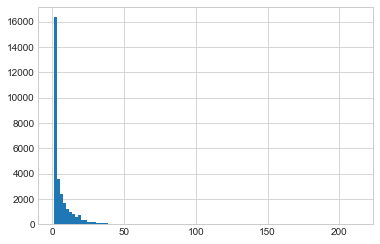

In [8]:
# Гистограмма
plt.hist(df['КолПозиций'],bins=100)
plt.show()

Возмем 20 случаныйх выборок по 300 элементов и проанализирем, средние показатели по выборкам

In [9]:
alternative = np.array([np.random.choice(df['КолПозиций'],300) for i in range(20)])

In [10]:
# Расчитаем основные статистики по каждой полученной выборке
alternative_indicators_pos = np.array([alternative.mean(axis=1),alternative.std(axis=1),\
                                   np.median(alternative,axis=1),np.quantile(alternative,0.25,axis = 1),\
                                   np.quantile(alternative,0.75,axis = 1)])
# Возмем средние статистики по по каждой выборке
alternative_indicators_pos_means = alternative_indicators_pos.mean(axis = 1)
alternative_indicators_pos_means

array([6.4005    , 8.46998344, 3.075     , 1.0375    , 7.975     ])

In [11]:
# средневыборочные показатели
print('Cредневыборочные показатели:'+'\n')
print('Среднее значение -', alternative_indicators_pos_means[0])
print('Стандартное отклонение -', alternative_indicators_pos_means[1])
print('медиана -', alternative_indicators_pos_means[2])
print('первый квартиль -', alternative_indicators_pos_means[3])
print('четвертый квартиль -', alternative_indicators_pos_means[4])

Cредневыборочные показатели:

Среднее значение - 6.400499999999999
Стандартное отклонение - 8.469983439539181
медиана - 3.075
первый квартиль - 1.0375
четвертый квартиль - 7.975


In [12]:
# Сравним показатели генеральной сосокупности и средневыборонче показатели
df_ind_pos = pd.DataFrame([general_indicators_pos,alternative_indicators_pos_means])
df_ind_pos.columns=['mean','std','median','q1','q3']
df_ind_pos['Тип'] = ['Генеральная совокупность', 'Средневыборочное']
df_ind_pos

,mean,std,median,q1,q3,Тип
0,6.40557,8.817552,3.000,1.0000,8.000,Генеральная совокупность
1,6.40050,8.469983,3.075,1.0375,7.975,Средневыборочное


In [13]:
# средневыборочное стандартное отклонение по средней,std и медиане
alternative_indicators_pos.std(axis = 1)[:3]


array([0.49771732, 1.37419956, 0.28613808])

Как видно, выборки из генеральной совокупности показывают схожие результаты, разбросы не большие

Посмтрим boxplot

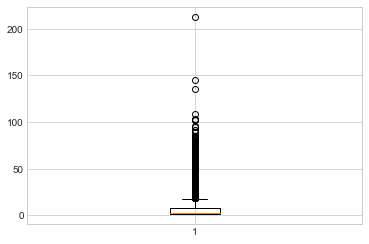

In [14]:
plt.boxplot(df['КолПозиций'])
plt.show()

ВЫбросов снизу нет, мниимальное количесвто позиций в счете - 1. выбросы сверху 1,5 от межквартильного растояния

In [15]:
# Выбросы сверху
outliers_pos = [i for i in df['КолПозиций'] if i >(q_3_pos+i_q_pos*1.5)]
print ('Количество выбросов - ', len(outliers_pos)  )
print ('минимальное значение - ', min(outliers_pos)  )

Количество выбросов -  2345
минимальное значение -  19


слишком много выбросов, увеличим коэф до 4

In [16]:
# Выбросы сверху
outliers_pos = [i for i in df['КолПозиций'] if i >(q_3_pos+i_q_pos*4)]
print ('Количество выбросов - ', len(outliers_pos)  )
print ('минимальное значение - ', min(outliers_pos)  )

Количество выбросов -  473
минимальное значение -  37


In [17]:
# удалим выбросы
df_clean_pos = df[df['КолПозиций']<=37]

In [18]:
df_clean_pos

,Номер,Дата,Контрагент,СуммаСчета,КолПозиций,Год,Месяц,СтатусОтгрузки
0,0000-000001,2013-01-25 17:24:07,Боргус,26876.00,19,2013,1,Отгружен
1,0000-000002,2013-01-25 18:26:56,Спецтранс,16520.00,1,2013,1,Отгружен
2,0000-000003,2013-01-28 14:46:55,Спецтранс,3980.14,1,2013,1,Отгружен
3,0000-000004,2013-01-28 15:23:55,Спецтранс,6873.50,4,2013,1,Отгружен
4,0000-000005,2013-01-28 15:35:52,Спецтранс,5040.00,3,2013,1,Отгружен
...,...,...,...,...,...,...,...,...
30153,КИ00-003082,2020-08-28 17:15:44,КБ-НС,5900.00,2,2020,8,Не отгружен
30154,КИ00-003083,2020-08-28 17:35:52,ЦентрСнаб,13151.00,2,2020,8,Не отгружен
30156,КИ00-003085,2020-08-28 17:59:40,ПСТ-Строй,95948.00,5,2020,8,Не отгружен
30157,СС00-001452,2020-08-28 18:42:19,СК Дали,1110.00,3,2020,8,Не отгружен


In [19]:
df_clean_pos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29726 entries, 0 to 30159
Data columns (total 8 columns):
Номер             29726 non-null object
Дата              29726 non-null datetime64[ns]
Контрагент        29726 non-null object
СуммаСчета        29726 non-null float64
КолПозиций        29726 non-null int64
Год               29726 non-null category
Месяц             29726 non-null category
СтатусОтгрузки    29726 non-null category
dtypes: category(3), datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 1.4+ MB


In [20]:
df_clean_pos.describe()

,СуммаСчета,КолПозиций
count,2.972600e+04,29726.000000
mean,2.637446e+04,5.733499
std,5.976617e+04,6.596701
min,0.000000e+00,1.000000
25%,3.950325e+03,1.000000
50%,1.094850e+04,3.000000
75%,2.863820e+04,8.000000
max,3.751000e+06,37.000000


Как выидно при небольшом уменьшении данных, std уменьшилось почти на четверть

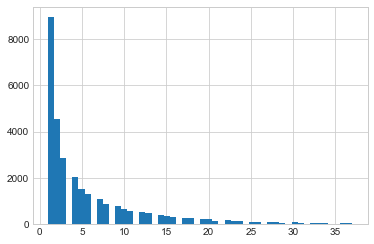

In [21]:
plt.hist(df_clean_pos['КолПозиций'],bins=50)
plt.show()

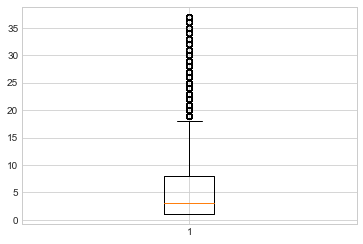

In [22]:
plt.boxplot(df_clean_pos['КолПозиций'])
plt.show()

Теперь графическое представление данных более четко смотриться

Рассмотрим , распредлние среднего количества позиций в счете по клиентам. Возмем  сто самых важных клиентов (по объему выставленных позиций). с маскимальным количеством выставлнных позиций. Отсортируем ао убыванию количества позиций в счете

In [23]:
customers_pos= df_clean_pos.groupby(['Контрагент']).agg({'КолПозиций':['sum','mean','std','median']})
customers_pos.sort_values(by=[('КолПозиций','sum')],ascending=False, inplace=True)
customers_pos =customers_pos.head(100).sort_values(by=[('КолПозиций','mean')],ascending=False)
customers_pos

КолПозиций                             
                                      sum       mean        std median
Контрагент                                                            
АСК ООО                               212  17.666667  13.068584   14.5
ИНЖСТРОЙ СПБ ООО                      326  13.040000  10.639862    9.0
Ростовский Малоэтажный Квартал        101  11.222222   7.361688   11.0
СК "ТИТАН"                           1989  11.174157  10.345337    8.0
СК-СТАНДАРТ ООО                       232  11.047619  10.007378   10.0
...                                   ...        ...        ...    ...
Луч                                   101   2.244444   1.568954    2.0
Арсенал Групп                         591   2.073684   2.127497    1.0
Латрэс                                178   1.977778   1.381887    1.5
АЛЬБАТРОС ООО                         140   1.917808   2.665382    1.0
Арсенал-10                            295   1.745562   1.569917    1.0

[100 rows x 4 columns]

Как видно, стандартное отклоннение около среднего значения, что говорит о большом разбросе. Таким образом трудно предсказать
сколкьо будет позиций в каждой конретной заявке.

Проведем однофакторный диспресионный анализ и выясним, имеет ли стастистически значимое влияние контрагент на количесвто позиций в счете с уровнем значимости 0,95

In [24]:
# Контрагенты, которые попали в наш список
clients_filtеr = customers_pos.index
# датафрейм только по выбранным клиентам 
df_clients_filtеr= df_clean_pos[df_clean_pos['Контрагент'].isin(clients_filtеr)]

In [25]:
alpha = 0.05
k1= len(clients_filtеr)-1
y_mean = df_clients_filtеr['КолПозиций'].mean()
n = len(df_clients_filtеr)
k2 = n-len(clients_filtеr)
(k1,k2,n,y_mean)

(99, 27846, 27946, 5.864452873398697)

In [26]:
# отклонения дисперсии между клиентами
s2b = 0
#  отклонения внутри клиента 
s2w = 0
# Посчитаем их
for i in clients_filtеr:
    m = df_clients_filtеr[df_clients_filtеr['Контрагент']==i]['КолПозиций']
    s2b+=((m.mean()-y_mean)**2)*len(m)
    s2w+=((m-m.mean())**2).sum()
(s2b,s2w)    

(134248.65879922037, 1112063.8886852146)

In [27]:
# оценки дисперсий:
sigma2b = s2b/k1
sigma2w = s2w/k2

(sigma2b ,sigma2w )

(1356.0470585779835, 39.93621664458861)

In [28]:
# значение статистики 𝐹
F = sigma2b / sigma2w
F

33.95532107225107

In [29]:
# распределение Фишера с параметрами k_1 и k_2 
F_crit = stats.f.ppf(1 - alpha, k1, k2)
F_crit

1.2452850324076419

Видим, что 
F>Fcrit
, поэтому заключаем, что отличие количества поизиций в счете, действительно является статистически значимым в замвсимости от контрагента.



ТЕПЕРЬ ПРОАНАЛИЗИРУЕМ ПОКАЗАТЕЛЬ СУММА СЧЕТА

In [30]:
print('Среднее значение -', df['СуммаСчета'].mean())
print('Стандартное отклонение -', df['СуммаСчета'].std())
print('дисперсия -', df['СуммаСчета'].var())
print('минимальное значение -', df['СуммаСчета'].min())
print('максимальное значение -', df['СуммаСчета'].max())
print('медиана -', df['СуммаСчета'].median())
print('первый квартиль -', df['СуммаСчета'].quantile(0.25))
q_1_amount = df['СуммаСчета'].quantile(0.25)
q_3_ammount = df['СуммаСчета'].quantile(0.75)
print('третий квартиль -', q_3_pos)
i_q_ammount = df['СуммаСчета'].quantile(0.75)-df['СуммаСчета'].quantile(0.25)
print('интерквартильное расстояние -', i_q_ammount)
general_indicators_ammount = np.array([df['СуммаСчета'].mean(),df['СуммаСчета'].std(),\
                                   df['СуммаСчета'].median(),df['СуммаСчета'].quantile(0.25),df['СуммаСчета'].quantile(0.75)])


Среднее значение - 29045.61251027851
Стандартное отклонение - 70030.0365007433
дисперсия - 4904206012.295439
минимальное значение - 0.0
максимальное значение - 3751000.0
медиана - 11237.3
первый квартиль - 4005.45
третий квартиль - 8.0
интерквартильное расстояние - 25917.1325


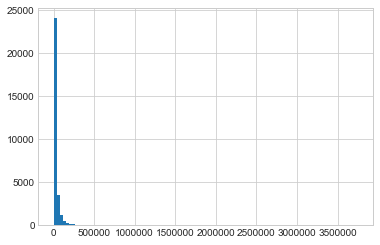

In [31]:
# Гистограмма
plt.hist(df['СуммаСчета'],bins=100)
plt.show()

Возмем 20 случаныйх выборок по 300 элементов и проанализирем, средние показатели по выборкам

In [32]:
alternative = np.array([np.random.choice(df['СуммаСчета'],300) for i in range(20)])

In [33]:
# Расчитаем основные статистики по каждой полученной выборке
alternative_indicators_amount = np.array([alternative.mean(axis=1),alternative.std(axis=1),\
                                   np.median(alternative,axis=1),np.quantile(alternative,0.25,axis = 1),\
                                   np.quantile(alternative,0.75,axis = 1)])
# Возмем средние статистики по по каждой выборке
alternative_indicators_amount_means = alternative_indicators_amount.mean(axis = 1)
alternative_indicators_amount_means

array([28218.53347833, 63533.81115112, 11304.98025   ,  3873.807125  ,
       28621.83675   ])

In [34]:
# средневыборочные показатели
print('Cредневыборочные показатели:'+'\n')
print('Среднее значение -', alternative_indicators_amount_means[0])
print('Стандартное отклонение -', alternative_indicators_amount_means[1])
print('медиана -', alternative_indicators_amount_means[2])
print('первый квартиль -', alternative_indicators_amount_means[3])
print('четвертый квартиль -', alternative_indicators_amount_means[4])

Cредневыборочные показатели:

Среднее значение - 28218.53347833333
Стандартное отклонение - 63533.81115112058
медиана - 11304.98025
первый квартиль - 3873.8071250000003
четвертый квартиль - 28621.83675


In [35]:
# Сравним показатели генеральной сосокупности и средневыборончные показатели
df_ind_am = pd.DataFrame([general_indicators_ammount,alternative_indicators_amount_means])
df_ind_am.columns=['mean','std','median','q1','q3']
df_ind_am['Тип'] = ['Генеральная совокупность', 'Средневыборочное']
df_ind_am

,mean,std,median,q1,q3,Тип
0,29045.612510,70030.036501,11237.30000,4005.450000,29922.58250,Генеральная совокупность
1,28218.533478,63533.811151,11304.98025,3873.807125,28621.83675,Средневыборочное


In [36]:
# средневыборочное стандартное отклонение по средней,std и медиане
alternative_indicators_amount.std(axis = 1)[:3]


array([ 4424.9455709 , 40317.55093003,  1138.11420384])


Посмтрим boxplot

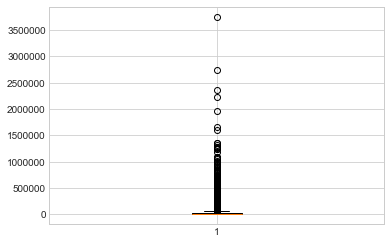

In [37]:
plt.boxplot(df['СуммаСчета'])
plt.show()

In [38]:
# Выбросы сверху
outliers_amount = [i for i in df['СуммаСчета'] if i >(q_3_ammount+i_q_ammount*1.5)]
print ('Количество выбросов - ', len(outliers_amount)  )
print ('минимальное значение - ', min(outliers_amount)  )

Количество выбросов -  2896
минимальное значение -  68889.0


1,5 - слишком мало, будем использовать - 10

In [39]:
# Выбросы сверху
outliers_amount = [i for i in df['СуммаСчета'] if i >(q_3_ammount+i_q_ammount*10)]
print ('Количество выбросов - ', len(outliers_amount)  )
print ('минимальное значение - ', min(outliers_amount)  )

Количество выбросов -  248
минимальное значение -  289390.0


In [40]:
# удалим выбросы сверху
df_clean_amount = df[df['СуммаСчета']<=289390]

In [41]:
df_clean_amount.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29913 entries, 0 to 30159
Data columns (total 8 columns):
Номер             29913 non-null object
Дата              29913 non-null datetime64[ns]
Контрагент        29913 non-null object
СуммаСчета        29913 non-null float64
КолПозиций        29913 non-null int64
Год               29913 non-null category
Месяц             29913 non-null category
СтатусОтгрузки    29913 non-null category
dtypes: category(3), datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 1.5+ MB


In [42]:
# посмотрим выбросы снизу
outliers_amount = [i for i in df['СуммаСчета'] if i <(q_1_amount-i_q_ammount*0.15)]
print ('Количество выбросов - ', len(outliers_amount)  )
print ('максимальное значение - ', max(outliers_amount)  )

Количество выбросов -  56
максимальное значение -  117.0


In [43]:
# удалим выбросы снизу
df_clean_amount = df_clean_amount[df_clean_amount['СуммаСчета']>=117]

In [44]:
df_clean_amount.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29858 entries, 0 to 30158
Data columns (total 8 columns):
Номер             29858 non-null object
Дата              29858 non-null datetime64[ns]
Контрагент        29858 non-null object
СуммаСчета        29858 non-null float64
КолПозиций        29858 non-null int64
Год               29858 non-null category
Месяц             29858 non-null category
СтатусОтгрузки    29858 non-null category
dtypes: category(3), datetime64[ns](1), float64(1), int64(1), object(2)
memory usage: 1.5+ MB


In [45]:
df_clean_amount.describe()

,СуммаСчета,КолПозиций
count,29858.000000,29858.000000
mean,24783.715615,6.238228
std,36843.425587,8.220213
min,117.000000,1.000000
25%,3992.835000,1.000000
50%,11099.500000,3.000000
75%,29210.825000,8.000000
max,289390.000000,102.000000


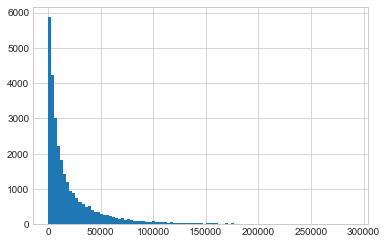

In [46]:
# Гистограмма
plt.hist(df_clean_amount['СуммаСчета'],bins=100)
plt.show()

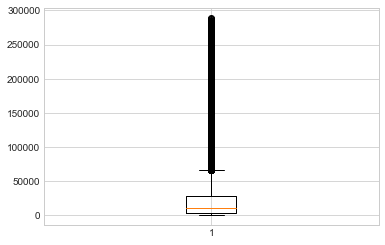

In [47]:
plt.boxplot(df_clean_amount['СуммаСчета'])
plt.show()

Рассмотрим , распредлние среднего количества позиций в счете по клиентам. Возмем сто самых важных клиентов (по объему выставленных позиций). с маскимальным количеством выставлнных позиций. Отсортируем по убыванию количества позиций в счете

In [48]:
customers_am= df_clean_amount.groupby(['Контрагент']).agg({'СуммаСчета':['sum','mean','std','median']})
customers_am.sort_values(by=[('СуммаСчета','sum')],ascending=False, inplace=True)
customers_am =customers_am.head(150).sort_values(by=[('СуммаСчета','mean')],ascending=False)
customers_am

СуммаСчета                                        
                           sum           mean           std     median
Контрагент                                                            
ФГБОУ ВПО «СПбГПУ»   258720.00  258720.000000           NaN  258720.00
СК ШЭН ХАО           200039.00  200039.000000           NaN  200039.00
Сбербанк России      199200.00  199200.000000           NaN  199200.00
КАППА                192678.85  192678.850000           NaN  192678.85
ГАЗПРОМСТРОЙИНВЕСТ   191585.00  191585.000000           NaN  191585.00
...                        ...            ...           ...        ...
Латрэс               689234.41    7658.160111  12892.351534    3674.50
Коска декор          243985.41    7624.544063  12257.622721    2526.50
Гефест               299920.80    6120.832653   6785.240668    3800.00
ПРОЕМ               1049905.68    5171.949163   3893.977937    4290.00
АЛЬБАТРОС ООО        255813.08    3504.288767   4180.078605    1500.00

[150 rows x 4 columns]

In [49]:
customers_am.sort_values(by=[('СуммаСчета','sum')],ascending=False)

СуммаСчета                                        
                            sum           mean           std     median
Контрагент                                                             
ПСТ-Строй           68419030.77   42842.223400  44175.496163   29200.00
Авалон              67776139.08   27186.578051  36320.766724   14134.00
ЦентрСнаб           65262101.73   20368.945609  32814.016108    8790.53
Кратон              58734417.52   28692.925022  32265.521625   17568.00
РОСБИЛД ООО         48937028.19   42739.762611  55106.643354   20276.40
...                         ...            ...           ...        ...
Сбербанк России       199200.00  199200.000000           NaN  199200.00
ЛСР. Базовые          198992.15   66330.716667  14829.006023   74798.00
КАППА                 192678.85  192678.850000           NaN  192678.85
ГАЗПРОМСТРОЙИНВЕСТ    191585.00  191585.000000           NaN  191585.00
СТРОЙМАШ ООО          189000.00  189000.000000           NaN  189000.00

[150 rows x 4 columns]

Как видно, стандартное отклоннение больше среднего значения суммы счета, что говорит о большом разбросе. Таким образом трудно предсказать на какую смму будет счет по заявке

Проведем однофакторный диспресионный анализ и выясним, имеет ли стастистически значимое влияние контрагент на количесвто позиций в счете с уровнем значимости 0,95

In [50]:
# Контрагенты, которые попали в наш список
clients_filtеr = customers_am.index
# датафрейм только по выбранным клиентам 
df_clients_filtеr= df_clean_amount[df_clean_amount['Контрагент'].isin(clients_filtеr)]

In [51]:
alpha = 0.05
k1= len(clients_filtеr)-1
y_mean = df_clients_filtеr['СуммаСчета'].mean()
n = len(df_clients_filtеr)
k2 = n-len(clients_filtеr)
(k1,k2,n,y_mean)

(149, 28498, 28648, 25217.887997416918)

In [52]:
# отклонения дисперсии между клиентами
s2b = 0
#  отклонения внутри клиента 
s2w = 0
# Посчитаем их
for i in clients_filtеr:
    m = df_clients_filtеr[df_clients_filtеr['Контрагент']==i]['СуммаСчета']
    s2b+=((m.mean()-y_mean)**2)*len(m)
    s2w+=((m-m.mean())**2).sum()
(s2b,s2w)    

(4756138875212.85, 35117704638525.64)

In [53]:
# оценки дисперсий:
sigma2b = s2b/k1
sigma2w = s2w/k2

(sigma2b ,sigma2w )

(31920395135.656708, 1232286639.0106547)

In [54]:
# значение статистики 𝐹
F = sigma2b / sigma2w
F

25.9033849147988

In [55]:
# распределение Фишера с параметрами k_1 и k_2 
F_crit = stats.f.ppf(1 - alpha, k1, k2)
F_crit

1.1985494310490816

Видим, что F>Fcrit , поэтому заключаем, что отличие количества поизиций в счете, действительно является статистически значимым в замвсимости от контрагента.

Рассмотрим взаимосвязь между количеством позиций в счете и суммой счета

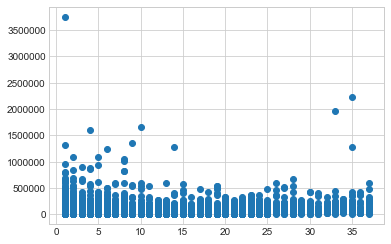

In [56]:
plt.scatter(df_clean_pos['КолПозиций'],df_clean_pos['СуммаСчета'])

Уберем сета больше 150 000 

In [57]:
df_clean_pos = df_clean_pos[df_clean_pos['СуммаСчета']<150000]

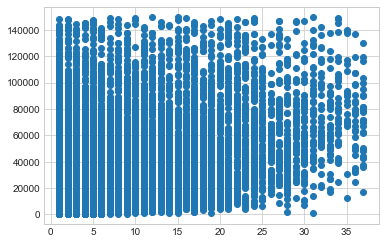

In [58]:
plt.scatter(df_clean_pos['КолПозиций'],df_clean_pos['СуммаСчета'])

Посчитаем коэфициент кореляции Пирсона

In [59]:
df_clean_pos[['КолПозиций', 'СуммаСчета']].corr()

,КолПозиций,СуммаСчета
КолПозиций,1.000000,0.488832
СуммаСчета,0.488832,1.000000


Как ни странно, корреляция очень слабая. Казалось бы, чем больше позиций , тем больше должен быть счет.
ПРоверим вдруг эта заивсимость не прямая.

Посчитаем коэфициент Кендала

In [60]:
df_clean_pos[['КолПозиций', 'СуммаСчета']].corr(method='kendall')

,КолПозиций,СуммаСчета
КолПозиций,1.000000,0.374436
СуммаСчета,0.374436,1.000000


Здесь еще хуже. Получается, счета с небольшим количеством позиций. которые используют меньше ресурсов, при этом дают большую экономическую отдачу.. То есть двойной экномический эффект

Попробуем спрогнозировать сумму счета на основании количества позиций в счет через линейную регрессию. Хотя судя по графику это абсолютно бесполезно.

In [61]:
X_test = pd.DataFrame(df['КолПозиций'])
Y_test = pd.DataFrame(df['СуммаСчета'])

In [62]:
lr=LinearRegression()

In [63]:
lr.fit(X_test,Y_test)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [64]:
Y_pred = lr.predict(X_test)

In [65]:
r2_score(Y_test,Y_pred)

0.18764465022108467

Не пригодно для использования

In [66]:
df_clean_pos

,Номер,Дата,Контрагент,СуммаСчета,КолПозиций,Год,Месяц,СтатусОтгрузки
0,0000-000001,2013-01-25 17:24:07,Боргус,26876.00,19,2013,1,Отгружен
1,0000-000002,2013-01-25 18:26:56,Спецтранс,16520.00,1,2013,1,Отгружен
2,0000-000003,2013-01-28 14:46:55,Спецтранс,3980.14,1,2013,1,Отгружен
3,0000-000004,2013-01-28 15:23:55,Спецтранс,6873.50,4,2013,1,Отгружен
4,0000-000005,2013-01-28 15:35:52,Спецтранс,5040.00,3,2013,1,Отгружен
...,...,...,...,...,...,...,...,...
30153,КИ00-003082,2020-08-28 17:15:44,КБ-НС,5900.00,2,2020,8,Не отгружен
30154,КИ00-003083,2020-08-28 17:35:52,ЦентрСнаб,13151.00,2,2020,8,Не отгружен
30156,КИ00-003085,2020-08-28 17:59:40,ПСТ-Строй,95948.00,5,2020,8,Не отгружен
30157,СС00-001452,2020-08-28 18:42:19,СК Дали,1110.00,3,2020,8,Не отгружен


Проанализируем счета по которым были отгрузки, и которые отменили (Не отгружен). Отгружен поменям на 1, не отгружен на 0

In [67]:
d= {'Отгружен':1,'Не отгружен':0}

In [68]:
df_clean_pos['СтатусОтгрузки'] = df_clean_pos['СтатусОтгрузки'].map(d)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [69]:
df_clean_pos

,Номер,Дата,Контрагент,СуммаСчета,КолПозиций,Год,Месяц,СтатусОтгрузки
0,0000-000001,2013-01-25 17:24:07,Боргус,26876.00,19,2013,1,1
1,0000-000002,2013-01-25 18:26:56,Спецтранс,16520.00,1,2013,1,1
2,0000-000003,2013-01-28 14:46:55,Спецтранс,3980.14,1,2013,1,1
3,0000-000004,2013-01-28 15:23:55,Спецтранс,6873.50,4,2013,1,1
4,0000-000005,2013-01-28 15:35:52,Спецтранс,5040.00,3,2013,1,1
...,...,...,...,...,...,...,...,...
30153,КИ00-003082,2020-08-28 17:15:44,КБ-НС,5900.00,2,2020,8,0
30154,КИ00-003083,2020-08-28 17:35:52,ЦентрСнаб,13151.00,2,2020,8,0
30156,КИ00-003085,2020-08-28 17:59:40,ПСТ-Строй,95948.00,5,2020,8,0
30157,СС00-001452,2020-08-28 18:42:19,СК Дали,1110.00,3,2020,8,0


In [70]:
# Общие веротности счета быть отгруженным, в %
df_clean_pos['СтатусОтгрузки'].value_counts()/len(df_clean_pos['СтатусОтгрузки'])*100

1    78.759541
0    21.240459
Name: СтатусОтгрузки, dtype: float64

(array([ 6178., 22908.]), array([0. , 0.5, 1. ]), <a list of 2 Patch objects>)

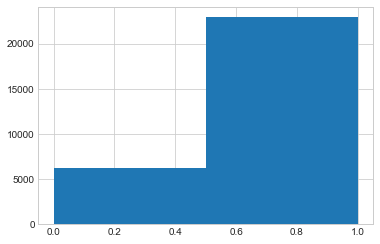

In [71]:
plt.hist(df_clean_pos['СтатусОтгрузки'],bins=2)

Рассмотрим вероятность подтверждения счета в зависимости от количества позиций в нем

In [72]:
df_clean_pos_=df_clean_pos.copy()
df_clean_pos_['СтатусОтгрузки']=df_clean_pos_['СтатусОтгрузки'].astype('int')
posishion_decision= df_clean_pos_.groupby(['КолПозиций']).agg({'СтатусОтгрузки':['sum','count']})
d= posishion_decision['СтатусОтгрузки'][['sum']].values
c= posishion_decision['СтатусОтгрузки'][['count']].values
posishion_decision['Доля'] =d/c
posishion_decision.sort_values(by=['Доля'],ascending=False)


СтатусОтгрузки            Доля
                      sum count          
КолПозиций                               
30                     65    70  0.928571
29                     58    63  0.920635
25                     92   102  0.901961
28                     69    78  0.884615
34                     29    33  0.878788
33                     36    41  0.878049
31                     40    46  0.869565
18                    207   239  0.866109
24                    113   132  0.856061
27                     56    66  0.848485
20                    176   208  0.846154
37                     25    30  0.833333
36                     24    29  0.827586
11                    458   564  0.812057
15                    290   359  0.807799
10                    514   642  0.800623
21                    115   144  0.798611
14                    324   406  0.798030
22                    118   148  0.797297
23                    112   141  0.794326
32                     27    34  0.794118
2                    3546  4483  0.790988
1                    7007  8860  0.790858
12                    398   504  0.789683
16                    246   313  0.785942
4                    1565  1997  0.783676
13                    357   458  0.779476
6                     982  1271  0.772620
9                     590   764  0.772251
17                    200   259  0.772201
5                    1150  1493  0.770261
19                    174   226  0.769912
3                    2180  2838  0.768147
7                     822  1071  0.767507
8                     670   875  0.765714
26                     59    79  0.746835
35                     14    20  0.700000

Как видно при среднем количестве позиций в счете (6) веротяность составляет 77%, пр  медианном количестве (3) - 76,8 %. Что чуть ниже чем в средем по ГС

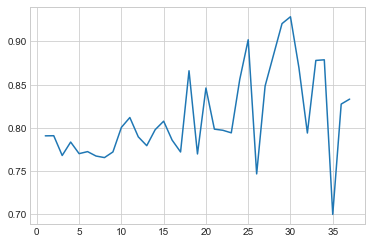

In [73]:
# Отборазим долю подтвержденных счетов в зависимости от количества позиций в счете
plt.plot(posishion_decision.index,posishion_decision['Доля'])

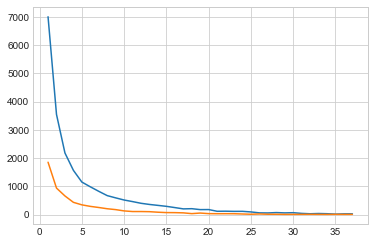

In [74]:
# Отобброзим сумму подтвержденных счетов в зависмости от количества позиций в счете
# Красным это сумма не подтвержденных счетов в звисимости о количества позиций в счетах
plt.plot(posishion_decision.index,d)
plt.plot(posishion_decision.index,(c-d))

Рассмотри статистику подтвержденых счетов в зависимости от клиента

In [75]:
# Возмем первых 100 клиннтов, которые делают осноной объем
decision_client= df_clean_pos_.groupby(['Контрагент']).agg({'СтатусОтгрузки':['sum','count']})
d= decision_client['СтатусОтгрузки'][['sum']].values
c= decision_client['СтатусОтгрузки'][['count']].values
decision_client['Доля'] =d/c
decision_client=decision_client.sort_values(by=[('СтатусОтгрузки','count')],ascending=False).head(99)
decision_client.sort_values(by=['Доля'],ascending=False)

СтатусОтгрузки            Доля
                            sum count          
Контрагент                                     
ИНЖСТРОЙ СПБ ООО             24    24  1.000000
ТИТАН ИНЖИНИРИНГ             27    27  1.000000
Артель                       42    42  1.000000
СК ДСС                       37    37  1.000000
ТЕПЛОКОМ ЗАО                 25    25  1.000000
...                         ...   ...       ...
СВАРГОС ООО                  16    35  0.457143
Сантехстрой                  17    38  0.447368
Авалон                     1040  2449  0.424663
Мостострой №6                 8    23  0.347826
Центр СПб ГУДП                0    42  0.000000

[99 rows x 3 columns]

In [76]:
decision_client.sort_values(by=[('СтатусОтгрузки','count')],ascending=False).head(99)

СтатусОтгрузки            Доля
                               sum count          
Контрагент                                        
ЦентрСнаб                     1929  3157  0.611023
Авалон                        1040  2449  0.424663
Кратон                        1949  1977  0.985837
ПСТ-Строй                     1516  1535  0.987622
ТехАтомСтрой                  1156  1359  0.850625
...                            ...   ...       ...
ДорГранитСтрой                  15    20  0.750000
СК-СТАНДАРТ ООО                 17    19  0.894737
Технология Комфорта             14    19  0.736842
ТеплоЭнерго                     15    18  0.833333
Спецкомплект                    11    18  0.611111

[99 rows x 3 columns]

Постороим модель логистисемкой регрессии используя три признака: Контрагент, кол. позиций в счете, сумма счета. Целевая переменная показатель тгружен чет или нет

In [77]:
X_train = df_clean_pos[['Контрагент','КолПозиций','СуммаСчета']]
X_train

,Контрагент,КолПозиций,СуммаСчета
0,Боргус,19,26876.00
1,Спецтранс,1,16520.00
2,Спецтранс,1,3980.14
3,Спецтранс,4,6873.50
4,Спецтранс,3,5040.00
...,...,...,...
30153,КБ-НС,2,5900.00
30154,ЦентрСнаб,2,13151.00
30156,ПСТ-Строй,5,95948.00
30157,СК Дали,3,1110.00


In [78]:
n=1
dict = {}
for i in set(X_train['Контрагент']):
    dict[i]=n
    n+=1
dict    

{'Строительная Компания Балт-Строй': 1,
 'НОВЫЙ СВЕТ-ЭКО': 2,
 'Тименбеков М.Т.': 3,
 'Сибстройэнерго': 4,
 'СТРОПКОМПЛЕКТ': 5,
 'Кайпорак': 6,
 'ТД ТехноСнабХим': 7,
 'Всеволжское ДРСУ': 8,
 'Феникс': 9,
 'Адмиралтейские верфи': 10,
 'Невский лакокрасочный завод': 11,
 'СтройКорпус': 12,
 'ЗДТ Ареопаг': 13,
 'НОВА': 14,
 'ПТК МИР': 15,
 'АЛЬБАТРОС ООО': 16,
 'ГК Алмаз': 17,
 'СМУ-9': 18,
 'ЭБС ООО': 19,
 'Электро-М ООО': 20,
 'МИР': 21,
 'ЮИТ Санкт-Петербург': 22,
 'ОНИКС ООО': 23,
 'ПРОМТЭК-СОЮЗ': 24,
 'Евроключ ООО': 25,
 'ИП Егоров Сергей Анатольевич': 26,
 'ПСК': 27,
 'Газстроймашина ООО': 28,
 'ТехСоюз': 29,
 'Балтийский завод': 30,
 'АТЛАНТ ООО': 31,
 'Авалон': 32,
 'Акварель': 33,
 'ПЕРСПЕКТИВА': 34,
 '31 ГПИСС': 35,
 'ТехСоюз-Строй': 36,
 'Склад': 37,
 'БВБ-Альянс-Тюмень': 38,
 'АЭСТ и С': 39,
 'Комплектация-СЗ': 40,
 'МТ групп': 41,
 'Стройторг': 42,
 'Завод Знамя труда': 43,
 'ТэчЭл': 44,
 'Медпром': 45,
 'Ситранс': 46,
 'ЕВРОИНВЕСТ ДЕВЕЛОПМЕНТ': 47,
 'Бикор БМП ООО': 48,
 '

In [79]:
X_train['Контрагент']=X_train['Контрагент'].map(dict)
X_train['Контрагент']=X_train['Контрагент'].astype('category')
X_train

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Контрагент,КолПозиций,СуммаСчета
0,379,19,26876.00
1,402,1,16520.00
2,402,1,3980.14
3,402,4,6873.50
4,402,3,5040.00
...,...,...,...
30153,53,2,5900.00
30154,84,2,13151.00
30156,546,5,95948.00
30157,429,3,1110.00


In [80]:
y_train = df_clean_pos['СтатусОтгрузки'].values
y_train

[1, 1, 1, 1, 1, ..., 0, 0, 0, 0, 0]
Length: 29086
Categories (2, int64): [0, 1]

In [81]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29086 entries, 0 to 30159
Data columns (total 3 columns):
Контрагент    29086 non-null category
КолПозиций    29086 non-null int64
СуммаСчета    29086 non-null float64
dtypes: category(1), float64(1), int64(1)
memory usage: 763.9 KB


In [82]:
lr=LogisticRegression(solver="liblinear")

In [83]:
lr.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [84]:
y_pred = lr.predict(X_train)

In [85]:
y_pred

array([1, 1, 1, ..., 1, 1, 1], dtype=int64)

In [86]:
y_pred.sum()/len(y_pred)*100

98.78635769786152

Уже видно что полчилась ерунда. У нас среднее подтверждение было 78%, а предсказывает почти 99%

In [87]:
accuracy_score(y_train,y_pred)

0.7868734098879185